<a id='top'></a>

# Modelling of the wiggles
---
**Author**: Michele Perna (mperna@cab.inta-csic.es)

**Latest Update**: 3 Aug 2023



The spatial undersampling in the NIRSpec IFS may result in apparent wiggles in the single-spaxel spectra close to the position of bright point sources, such as stars and QSOs. There is currently no correction in the pipeline for this; large spatial extraction regions are hence required to reduce the amplitude of the effect in extracted 1-D spectra (see Perna+2023, Law+2023). 

For isolated point sources, for which the extraction of spatially resolved information is not possible, this effect is irrelevant, as when the flux is integrated over a large aperture the wiggles disappear. However, there are situations where a point source overlaps with extended emission, thus requiring to disentangle the flux from both sources. This is the case, for instance, in studies of QSO hosts and their close environment.

This notebook shows how to subtract the spurious wiggles at single-spaxel level. It works together with a json file containing all information required for a proper modelling of the 1d spectra, and an ascii file containing the emission lines to be masked during the wiggles modelling. Detailed description of the parameters in the json files can be found below. 

A NIRSpec data-cube to test this notebook is available for download at this link: 
https://drive.google.com/file/d/18sn9IcJ-QzNEKXUpQpVPozLiOrneN7Nj/view?usp=drive_link


<div class="alert alert-block alert-info">
    <h3><u><b>Notebook Goals</b></u></h3>
    <ul>Working with the NIRSpec IFS data of the proposal ID 1220 (PI: N. Luetzgendorf), presented in Perna et al. 2023 as part of the GA-NIFS project.</ul>
        <ul>We will:</ul>    
<ul>
    <li>Fit and subtract the wiggles of the 1d spectrum associated with the brithest spaxel, i.e. the one with highest signal-to-noise ratio (S/N).</li>
    <li>Identify all spaxels possibly affected by wiggles, model and subtract them.</li>
    <li>Generate a new cube without wiggles</li>    
    <li>Produce a couple of figures showing the spectra before and after the wiggles subtraction</li>    
</ul>
<ul>    
    This notebook is a work in progress, and is subject to change. Please e-mail me if I need to correct something. For the sake of simplicity, I do not report in this notebook a few additional corrections which could slighly improve the wiggles correction; please e-mail me if you need to further information about them.  
</ul>
</div>

<a id='import'></a>

### Imports

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from mgefit import cap_mpfit as mpfit
from scipy.signal import savgol_filter
import random as rn
import json, csv
from astropy import constants as k


<a id='import'></a>

### Input paramenters

Input parameters should be collected in the json file 'config_wigglescorr_lbqs0302.json'. It follows a breif description of the main parameters 


- sourcename : name of the target (e.g. 'LBQS0302+JIL')
- pathcube_input : path of the input cube
- cube_input : name of the input cube
- pos_nucleus : x and y position (in pixel) of the target nucleus (e.g. [16,16] for LBQS0302)
- z : redshift of the target
- r_integ : integration radius (in pixel) of the spectrum to be used as a reference during the fit of the wiggles (integrating over a large aperture the wiggles disappear, and we can have a good reference for the intrinsic shape of the 1d spectrum)
- mask_Hacomplex : wavelenght range (in micron, obs-frame) associated with bright BLR emission, to be excluded during the fit of the wiggles
- gap_window : wavelenght range (in micron, obs-frame) containing the gap between the two NIRSpec detectors
- con_to_be_subtracted : wavelenght ranges (in micron, obs-frame) to be used to define the continuum shape
- DV : define the wavelength range around each emission line (in km/s) to be excluded during the fit of the wiggles 
- f0 : frequency to be used for the initialization of fit of the 1d spectrum with highest S/N
- bf0i : define the boundaries of the fit for the wiggles frequency, for the 1d nuclear spectrum: the frequency will be forced to be within f0 - bf0[0] and f0 + bf0[1]  
- df0i : define the boundaries of the fit for the wiggles frequency for all off-nuclear spaxels, which will be forced to be within f0 - df0i[i] and f0 + df0i[i] during the iteration 'i' of the fit.



In [5]:
configuration_file = "config_wigglescorr_lbqs0302.json"
print("# Using configuration file: {:s}".format(configuration_file))
with open(configuration_file) as data_file:
    inputpar = json.loads(data_file.read())


pathcube_input = inputpar['pathcube_input']

    
z = float(inputpar['z'])
sourcename = inputpar['sourcename']
cube_input = inputpar['cube_input']
nuc_x, nuc_y, nuc_r = inputpar['pos_nucleus'][0], inputpar['pos_nucleus'][1], inputpar['r_integ']
print('# sourcename: ', sourcename, '\n# centred at the position  x, y = ', nuc_x, nuc_y)

# regions to be masked during the fit of the wiggles
mask_Hacomplex = inputpar['mask_Hacomplex']
gap_window = inputpar['gap_window']
DV = inputpar['DV']


# frequency parameters
f0  = inputpar['f0']  # initial estimate for the frequency of the wiggles. reasonable values are 20-40
bfi = inputpar['bf0'] # boundaries for the fit for the wiggles frequency, to be used for the 1d spectrum with highest S/N
df0i = inputpar['df0i'] # delta-frequence for the wiggles modelling, defined in the json file


# continuum intervals from the json file
con_to_be_subtracted = inputpar['con_to_be_subtracted']

c = k.c.to('km/s').value

# Using configuration file: config_wigglescorr_lbqs0302.json
# sourcename:  LBQS0302-0019+JIL 
# centred at the position  x, y =  16 16


<a id='import'></a>

### Functions

In [6]:

# cos_function 
def cos_fn(p,flags=False):
    model_freq   = p[0]
    Amp = p[1]
    y = Amp * np.cos(2 * np.pi * model_freq * x_model[flags] + np.pi/2*p[2]) + p[3]
    return y

def model(p, x=None , y=None, err=None, fjac=None):
    return (y- cos_fn(p,flag_mod))/err

def chisquare(p, x, y, err):
    mod = cos_fn(p,flag_mod)
    return np.sum((y-mod)**2/err**2.)

# the file linefeatures_vac.dat cointains the list of transitions that will be masked during the fit of the wiggles
# please modify this ascii file by including all transitions you may need to mask in your data-cube
def list_wave_lines_f():
    list_wave_lines = []
    list_lines = []
    input_file_linefeatures = 'linefeatures_vac.dat'
    with open(input_file_linefeatures, 'r') as infile:
        csv_reader = csv.reader(infile, delimiter=' ')
        for line in csv_reader:
            list_wave_lines.append(float(line[0]))
            list_lines.append(line[1])
    infile.close()

    list_wave_lines = np.array(list_wave_lines)
    list_lines = np.array(list_lines)
    return  list_wave_lines, list_lines

def set_plot_panels():
    plt.close('fig')
    global fig, ax, bx, cx
    fig = plt.figure(figsize=(12, 8))
    fig.subplots_adjust(hspace=0.03)

    #panel with frequencies
    ax = plt.subplot(3,1,3)
    ax.set_xlim([wave_um[0],wave_um[-1]])
    ax.set_ylim([-9,69])
    ax.set_xlabel(r'obs.-frame wavelength ($\mu$m)')
    ax.set_ylabel(r'frequency ($\mu$m$^{-1}$)')

    #panel with original spectra, and oscillations
    bx = plt.subplot(3, 1, 1)
    bx.set_ylim([-.08, 0.49])
    bx.set_xlim([wave_um[0], wave_um[-1]])
    bx.set_ylabel('flux (a.u.)')
    bx.set_xticks([])

    #panel with corrected spectrum
    cx = plt.subplot(3,1,2)
    cx.set_ylim([-.08, 0.49])
    cx.set_xlim([wave_um[0], wave_um[-1]])
    cx.set_ylabel('flux (a.u.)')
    cx.set_xticks([])

    for iltbf in range(len(lines_to_be_flagged)):
        ax.axvspan(lines_to_be_flagged[iltbf][0], lines_to_be_flagged[iltbf][1], alpha=0.1, color='red')
        bx.axvspan(lines_to_be_flagged[iltbf][0], lines_to_be_flagged[iltbf][1], alpha=0.1, color='red')
        cx.axvspan(lines_to_be_flagged[iltbf][0], lines_to_be_flagged[iltbf][1], alpha=0.1, color='red')

    ax.axvspan(gap_window[0], gap_window[1], alpha=0.2, color='orange')
    ax.axvspan(mask_Hacomplex[0], mask_Hacomplex[1], alpha=0.2, color='orange')


    

<a id='import'></a>

### Input cube and 1d integrated spectrum of the target

In [7]:
# read data cube and define the integrated spectrum, to be used as a reference 

pathfileLBQS = pathcube_input

# 
try:
    cube_input = cube_output
except NameError:
    cube_input = cube_input


    
hdu_01  = fits.open(pathcube_input + cube_input)
cube_01 = (hdu_01[1].data)
ecube_01 = (hdu_01[2].data)
h0_01   = hdu_01[1].header
target  = hdu_01[0].header["TARGPROP"]
px_size = h0_01['CDELT1']*3600 #arcsec
wave_um = (h0_01['CRVAL3']+h0_01['CDELT3']*np.arange(0,h0_01['NAXIS3'])) #um

dt = wave_um[1] - wave_um[0]
x_model = np.arange(wave_um.size)*dt

spec_ref = np.zeros(cube_01.shape[0])
for iy in range(cube_01.shape[1]):
    for jx in range(cube_01.shape[2]):
        if (iy - nuc_y)**2 + (jx- nuc_x)**2 <= nuc_r**2:
            spec_ref += np.nan_to_num(cube_01[:,iy,jx])

#normalise the spectrum it its maximum (in det1 or det2)
maxspec_ref = np.nanmax([np.nanmax(spec_ref[wave_um < gap_window[0]]), np.nanmax(spec_ref[wave_um > gap_window[1]])])
spec_ref = spec_ref / maxspec_ref


<a id='import'></a>

### Identify continuum emission and line features in the 1d spectrum

In [8]:
list_em_lines = list_wave_lines_f()[0]*(1+z)/1.e4 # obs-frame in micron

lines_to_be_flagged = [[]]*len(list_em_lines)

for i in range(len(list_em_lines)):
    lines_to_be_flagged[i] = [list_em_lines[i]*(1-DV/c), list_em_lines[i]*(1+DV/c)]
    



In [9]:
# define low-order polynomial, to separate
# the sinusoidal component to be modelled
con_model_order = 9
con_windows = np.full((len(wave_um)), False)
                      
for iltbf in range(len(con_to_be_subtracted)):
    con_windows[(wave_um > con_to_be_subtracted[iltbf][0]) & (wave_um < con_to_be_subtracted[iltbf][1])] = True




<a id='import'></a>

### Modelling of the wiggles

In [10]:
# this is the function used to model the wiggles in 1d spectra.

def fitwiggles(args):
    ix, iy, f_walls = args[0], args[1], args[2]
    
    
    global flag_fit, freq_mod_cen,sorted_l_bins_cen, best_freq_par, flag_mod, f0
        

    # correct_px is set to `r`
    # to repeat the fit as many times as needed to optimise the frequency trend 
    # This loop stops after 1 interation if f_walls is set to 2
    correct_px = 'r'

    while correct_px == 'r':

        # inizialization
        final_model = np.zeros((N_rep, spec_ref.size))
        l_bins = []
        f_bins = []

        # define the spectrum to be corrected
        
        if f_walls < 2: 
            print('\nspectrum from x,y =', ix, iy)
            print('iteration n. ', f_walls)
        elif f_walls > len(df0i):
            print('too many iterations!')
            break
        
        spec = np.nan_to_num(cube_01[:, iy, ix])
        maxspec = np.nanmax([ np.nanmax(spec[wave_um < gap_window[0]]), np.nanmax(spec[wave_um > gap_window[1]]) ])
        spec = spec / maxspec
        espec = hdu_01[2].data[:, iy, ix] / maxspec * 2
        espec[espec <= 0] = 1e-2



            
            

        spec_diff_poly = spec[con_windows] - spec_ref[con_windows]
        flx_con_mod = np.polyfit(wave_um[con_windows], spec_diff_poly, con_model_order)
        #flx_con_mod = np.polyfit(wave_um, spec - spec_ref, 7)
        model_con = np.poly1d(flx_con_mod)(wave_um)
        #model_con = np.poly1d(flx_con_mod)(wave_um)
        spec_to_be_modelled = spec - spec_ref - model_con

        
        if iplotF == 0:
            #set plot panels
            set_plot_panels()


        
        # repeat the fit for N_rep to increase the quality...
        for iN in range(N_rep):
            #print('iN: ', iN)
            Delta = 250 + np.random.randint(-60,250)
            for i_ch in range(Delta, wave_um.size + int(Delta / 2), int(Delta / 2)):

                # here I define two masks:
                # flag_mod, to define the model for the fit, and excluding all emission lines and features
                # which could affect the quality of the fit;
                # flag_fit, for the reconstruction of the oscillations with the best-fit results
                # the latter will present interpolations for the flag_mod masked regions
                if i_ch >= wave_um.size:
                    i_ch = wave_um.size -1
                    flag_fit = (wave_um > wave_um[i_ch -int(Delta/2)]) & (wave_um < wave_um[i_ch]) # at long wave, wiggles have higher freq, and we can use smaller ranges.
                    flag_mod = (wave_um > wave_um[i_ch - int(Delta/2)]) & (wave_um < wave_um[i_ch])
                #elif i_ch < 700:
                #    flag_fit = (wave_um > wave_um[i_ch - Delta]) & (wave_um < wave_um[i_ch - int(Delta/3)]) # at short wave, wiggles have higher freq, and we can use smaller ranges.
                #    flag_mod = (wave_um > wave_um[i_ch - Delta]) & (wave_um < wave_um[i_ch - int(Delta/3)])
                #
                else:
                    
                    flag_fit = (wave_um > wave_um[i_ch - Delta]) & (wave_um < wave_um[i_ch])
                    #define another array for the modelled oscillations
                    flag_mod = (wave_um > wave_um[i_ch - Delta]) & (wave_um < wave_um[i_ch])

                flag_fit[(wave_um > gap_window[0]) & (wave_um < gap_window[1])] = False  # exclude gap

                #plot wave ranges used to fit the wiggles
                #y_lrange = np.random.randint(-2, 40)
                #ax.plot([wave_um[i_ch - Delta], wave_um[i_ch]], [y_lrange, y_lrange], color='grey', alpha=0.2)

                # exclude Ha peak during the fit, but not during the reconstruction of the oscillations.
                # I am taking narrower range for more external regions

                #flag_mod[(wave_um > 2.78) & (wave_um < 2.83)] = False  
                
                for iltbf in range(len(lines_to_be_flagged)):
                    flag_mod[(wave_um > lines_to_be_flagged[iltbf][0]) & (wave_um < lines_to_be_flagged[iltbf][1])] = False
                flag_mod[(wave_um > gap_window[0]) & (wave_um < gap_window[1])] = False  # exclude gap

                # model params ................................
                # 
                p = []
                # frequency
                try:
                    # if already defined in a previous fit, the frequency will be initialised using the 
                    # trend fw(lambda) shown in the 3rd panel of the figure below
                    f0 = np.poly1d(best_freq_par)(wave_um[flag_mod].mean())
                    p.append([np.max([f0,0.1]), np.max([f0-df0i[f_walls],0.1]), f0 + df0i[f_walls]])
                except NameError:
                    # otherwise, the frequency will be initialised using the parameter defined in the json file
                    p.append([f0,  bfi[0], bfi[1]])
                    
                p.append([0.09, 0.005, 0.3])    # Amplitude
                p.append([0.5,  0.005, 0.995])  # phase
                p.append([0.03, -0.09, 0.09])   # continuum

                parinfo = []
                parinfo = [{'value': p[i][0], 'fixed': 0, 'limited': [1, 1], 'limits': [p[i][1], p[i][2]]} for i in range(len(p))]
                # ................................

                fa = {'x': wave_um[flag_mod], 'y': spec_to_be_modelled[flag_mod], 'err': espec[flag_mod]}

                m = mpfit.mpfit(model, parinfo=parinfo, functkw=fa, ftol=1e-15, xtol=1e-15, quiet=1)
                if (m.status <= 0):
                    print ('error message = ', m.errmsg)

                chi2red = chisquare(m.params, wave_um[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave_um[flag_mod].size - m.params.size)

                # repeat the fit, with random initializations for the initial parameters
                for k in range(60):
                    pbin = 20
                    for i in range(len(p)):
                        p[i][0]      = (int(rn.uniform(1, pbin))*(p[i][1]-p[i][2])/pbin +p[i][2]+1e-6)

                    parinfo = []
                    parinfo = [{'value': p[i][0], 'fixed': 0, 'limited': [1, 1], 'limits': [p[i][1], p[i][2]]} for i in range(len(p))]
                    m0 = mpfit.mpfit(model, parinfo=parinfo, functkw=fa, ftol=1e-15, xtol=1e-15, quiet=1)

                    chi2red_new = chisquare(m0.params, wave_um[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave_um[flag_mod].size - m0.params.size)

                    if chi2red_new < chi2red:
                        m = m0
                        chi2red = chi2red_new

                    final_model[iN][flag_fit] = cos_fn(m.params,flag_fit)

                if (f_walls < 3) & (iplotF == 0):
                    bx.plot(wave_um[flag_mod], spec_to_be_modelled[flag_mod], 'x', markersize=0.3,color='grey')
                
                
                l_bins.append(wave_um[flag_mod].mean())
                f_bins.append(m.params[0])

                if i_ch == wave_um.size -1: i_ch +=1 # to avoid repetion of last step in the loop


            if (iplotF == 0): 
                if (iN == 0):
                    bx.plot(wave_um, spec, label = 'single-spaxel spectrum')
                    bx.plot(wave_um, spec_ref, label = 'integrated spectrum')
                    bx.plot(wave_um, spec_to_be_modelled, label = 'wiggles', markersize= 1,color='grey')
                bx.plot(wave_um, final_model[iN], color = 'purple', alpha = 0.05)


        l_bins = np.array(l_bins)
        f_bins = np.array(f_bins)

        inds = l_bins.argsort()
        sorted_f_bins = f_bins[inds]
        sorted_l_bins = l_bins[inds]


        # here I mask the wave channels close to the gap between detectors, and close to Ha emission,
        # where the fit is more difficult and the frequencies may significantly vary from the general trend
        mask_freq_channels = np.ones_like(sorted_l_bins, dtype='bool')
        mask_freq_channels[(sorted_l_bins > gap_window[0]) & (sorted_l_bins < gap_window[1])] = False
        mask_freq_channels[(sorted_l_bins > mask_Hacomplex[0]) & (sorted_l_bins < mask_Hacomplex[1])] = False


        # <---
        freq_par = np.polyfit(sorted_l_bins[mask_freq_channels],sorted_f_bins[mask_freq_channels] , 5)
        freq_mod = np.poly1d(freq_par)(np.array(sorted_l_bins))

        if (iplotF == 0): 
            ax.plot(sorted_l_bins, sorted_f_bins, 'o', markersize=3, label = 'best-fit frequency')
            ax.plot(sorted_l_bins, freq_mod, 'black', label = 'polynomial fit')
        
        if (nuc_x == ix) & (nuc_y == iy):
            freq_mod_cen = freq_mod + 0
            sorted_l_bins_cen = sorted_l_bins + 0
            
        spec_corr = spec - np.median(final_model, axis=0) #+ model_con
        if (iplotF == 0): 
            ax.plot(sorted_l_bins, np.interp(sorted_l_bins,sorted_l_bins_cen,freq_mod_cen), alpha = 0.5)

            bx.plot(wave_um, np.median(final_model,axis=0),  label = 'model', color = 'red')
            bx.legend(loc='upper right')


            #cx.plot(wave_um, spec, label='single-spaxel spectrum')
            cx.plot(wave_um, spec_ref, color = 'orange', label = 'integrated spectrum')
            cx.plot(wave_um, spec_corr, color='darkblue', label='corrected single-spaxel spectrum', alpha=0.9)
            cx.plot(wave_um, -spec_ref - model_con + spec_corr, color='grey', label='residuals w.r.t. integrated spectrum', alpha=0.7)
            cx.legend(loc='upper right')

            plt.show(block=False)

        if f_walls == 0: #only for central spaxel spectrum
            update_freq_par = input('To update the reference trend for frequency, enter `y`')
            if update_freq_par == 'y':
                best_freq_par = freq_par


        if f_walls != 2:
            print('\nTo apply the correction to the spectrum in the data cube, enter `y`')
            print('To refine the fit before correction, enter `r`')
            print('else: enter `n`')
            correct_px = input()
        else:
            correct_px = 'y' # with f_walls = 2 we directly fit the oscillations with solid constraints, and correct for them without looking at results
            
        f_walls += 1

        if correct_px == 'y':
            return [ix, iy, spec_corr*maxspec]
    return

### Description of the algorithm used to fit the wiggles

As a first step, we fit the wiggles of the spectrum extracted from the brightest spaxel, the one with highest signal-to-noise ratio (S/N). 
We use a sinusoidal function to model the wiggles,
$y(w) = A \sin(2\pi f_w  w + \phi) + B$, where A is the amplitude, $f_w$ is the frequency in $1/\mu$m, $w$ is the wavelength, $\phi$ is the phase shift, and B is the continuum level. 


We repeat the process in small portions of the wavelength range ($\sim 0.1\mu$m), as many times as necessary to cover the entire spectrum. The combination of all best-fit truncated sinusoidal functions will hence reproduce the wiggles in the entire wavelength range. This combination is shown in the figure generated with the next cell. More in detail: 
the **top panel** shows the integrated spectrum (orange curve), the single-spaxel spectrum (blue), and the wiggles (grey). The red curve represents the best-fit model of the wiggles, obtained a a combination of all truncated sinusoidal functions. 

The **central panel** shows the single-spaxel spectrum after the correction for the wiggles (dark-blue), in comparison with the integrated spectrum (orange); the grey curve represents the new residuals with respect to the integrated spectrum.

The best-fit frequency of all truncated sinusoidal functions is used to construct a frequency trend as a function of the wavelength. This trend is shown in the **bottom panel** of the figure generated with the next cell. A low-order
polynomial function fitting these points is also reported. All panels display red and orange shaded regions (associated with the QSO emission lines, BLR emission and the gap between the two NIRSpec detectors) that are excluded during the fit.


This frequency trend $f_w$ is then used to fit the wiggles in all spaxels in the surrounding of the point-source. In fact, the $f_w$ trend is common to all single-spaxel spectra around the QSO peak, and can be used to better constrain the shape of the wiggles even for lower S/N spectra, or in masked regions (associated with strong emission lines, and the gap between the two detectors). Further detail in Perna+2023. 

fit the central pixel, and get a reference trend for frequency variations

spectrum from x,y = 16 16
iteration n.  0


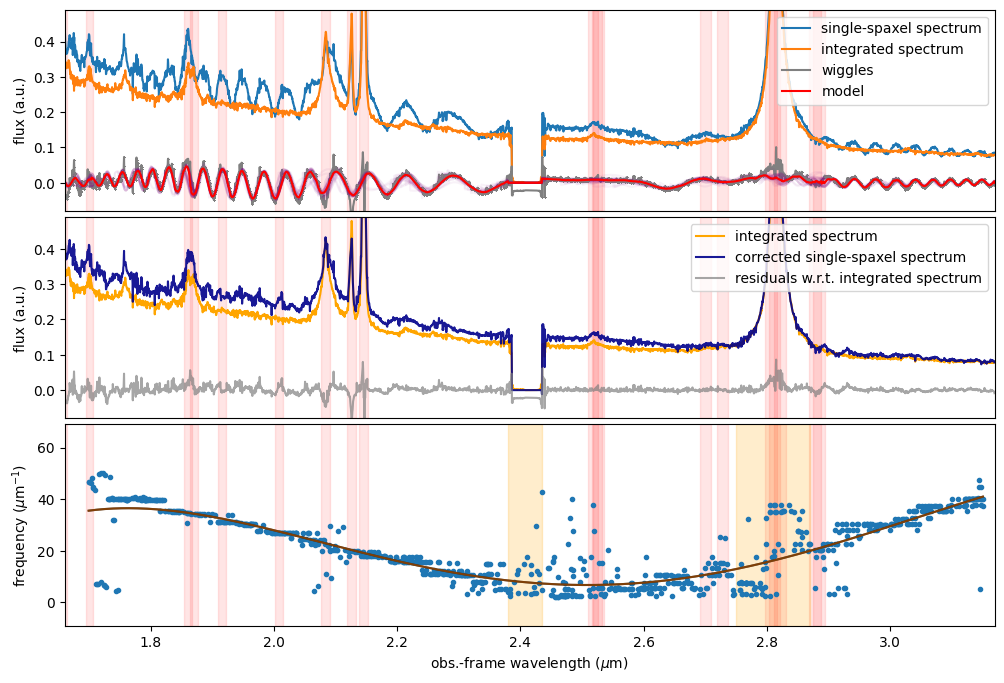

To update the reference trend for frequency, enter `y`y

To apply the correction to the spectrum in the data cube, enter `y`
To refine the fit before correction, enter `r`
else: enter `n`
r

spectrum from x,y = 16 16
iteration n.  1


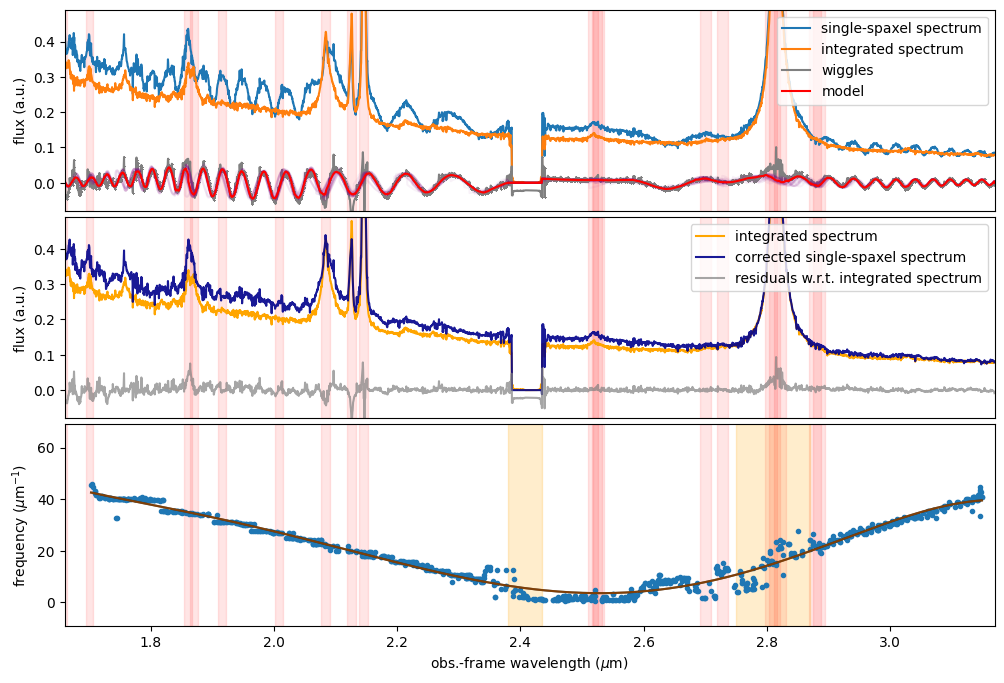


To apply the correction to the spectrum in the data cube, enter `y`
To refine the fit before correction, enter `r`
else: enter `n`
y


In [11]:
# perform an initial fit for the central pixel, to derive the freq(lambda) trend
print('fit the central pixel, and get a reference trend for frequency variations')
N_rep = 40
sorted_lf_bins = []

iplotF = 0 # show results in a plot

# f_walls is connected with df0i:
# f_walls = 0 is used to fit the brightest spaxel, and to obtain the frequency trend fw(lambda) 
f_walls = 0

#this takes some time...
sorted_lf_bins.append( fitwiggles([nuc_x, nuc_y, f_walls]) )


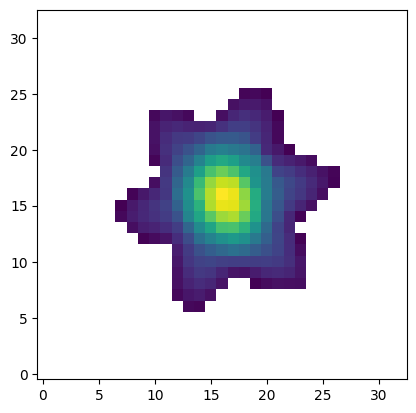

In [12]:
# here we identify the spaxels with enough continuum emission 
# and hence potentially affected by wiggles 

ima_mean = cube_01[con_windows].mean(axis=(0))

eima_mean = ecube_01[con_windows].mean(axis=(0))

LL = np.nanpercentile(eima_mean,50) 
ima_mean[np.where(ima_mean < 3*LL)] = 'nan'


plt.imshow(np.log10(ima_mean), origin = 'lower')
plt.show()


We now repeat the wiggles modelling for all the spaxels in the surrounding of the point-source. This is done using the frequency trend fw(lambda) identified above as a prior. 

In [13]:
# define tasks for the multiprocessing
N_rep = 80
tasks = []


# f_walls is connected with df0i:
# f_walls = 2 is used to fit the 1d spectra with more rigid boundaries for the frequency fw(lambda),
# corresponding to f0 +\- df0i[2], where f0 is extracted from the trend inferred from the modellisation of the brightest spaxel 
f_walls = 2


for iy in range(ima_mean.shape[0]):
    for ix in range(ima_mean.shape[1]):
        if np.isfinite(ima_mean[iy,ix]) & (~((ix == nuc_x) & (iy == nuc_y))):
            tasks.append((ix, iy, f_walls))
            
print(len(tasks), ': n. of spectra')


236 : n. of spectra


In [14]:

iplotF = 1 # avoid generation of plots, as they are not compatible with multiprocessing 

ncpu = 50 

import multiprocessing as mp
pool = mp.Pool(processes=ncpu)
print('Starting parallel processes ...')

results = []
index = 0
for tsk in tasks:
    results.append(pool.apply_async(fitwiggles, (tsk,)))
    
    


Starting parallel processes ...
done


In [15]:
for i in np.arange(len(results)):
    try:
        sorted_lf_bins.append(results[i].get())
    except:
        pass


In [16]:
try: cube_output
except NameError: cube_output = cube_input[:-5] + '_corrwigg.fits'

print('results to be collected in the file ', cube_output)


results to be collected in the file  LBQS0302-0019+JIL_jw1220_o002_CTX1041_v1.8.2_g235h-f170lp_corrwigg.fits


In [17]:
for i in range(len(sorted_lf_bins)):
    hdu_01[1].data[:,sorted_lf_bins[i][1],sorted_lf_bins[i][0]] = sorted_lf_bins[i][2]

hdu_01.writeto(pathcube_input + cube_output, overwrite=True)

print(pathcube_input + cube_output)
print('This is the end!')
hdu_01.close()

/misc/pacifico/jwst/mastDownload/LBQS0302-0019+JIL_p1220_o002/LBQS0302-0019+JIL_g235h-f170lp/DAcubes/LBQS0302-0019+JIL_jw1220_o002_CTX1041_v1.8.2_g235h-f170lp_corrwigg.fits
This is the end!


The following cells can be used to generate a few plots, and inspect the corrections applied at single-spaxel level.
The first cell is also showing some integrated spectra, proving that the shape of the spectrum is conserved.  

In [ ]:
hdu_01  = fits.open(pathcube_input + cube_input)
hdu_02  = fits.open(pathcube_input + cube_output)

cube_01 = (hdu_01[1].data)
cube_02 = (hdu_02[1].data)
CTX     = hdu_01[0].header['CRDS_CTX']

fig = plt.figure(figsize=(12, 4.5))
plt.xlim([wave_um[0],wave_um[-1]])
plt.ylim([-0.04,0.5])

for i in range(4,-1,-1):
    Npix = 0
    spec_in = np.zeros(cube_01.shape[0])
    spec_out = np.zeros(cube_02.shape[0])
    for iy in range(cube_01.shape[1]):
        for jx in range(cube_01.shape[2]):
            if (iy - nuc_y)**2 + (jx- nuc_x)**2 <= i**2:
                spec_in += np.nan_to_num(cube_01[:,iy,jx])
                spec_out += np.nan_to_num(cube_02[:,iy,jx])
                Npix +=1
    plt.plot(wave_um,spec_out/np.nanmax(spec_out)-0.02*(5-i),alpha=0.8,label=str(Npix)+' px')
    plt.plot(wave_um,spec_in/np.nanmax(spec_in)-0.02*(5-i),alpha=0.5,linestyle='dotted',color='k')

plt.xlabel(r'obs.-frame wavelength ($\mu$m)',fontsize='x-large',fontweight='roman')

plt.ylabel(r'flux (a.u.)',fontsize='x-large',fontweight='roman')
plt.title('integrated spectra for increasing radius')
plt.legend()
plt.savefig('figuraLBQSnew.pdf' )

plt.show()

In [ ]:

plt.close('all')
fig,ax=plt.subplots(2,1,figsize=(12,6),sharex=True,gridspec_kw={'hspace':0,'height_ratios':[1,0.65]})
ax[0].set_xlim([wave_um[0],wave_um[-1]])
ax[0].set_ylim([-0.05,1.1])
ax[0].plot(wave_um, spec_ref,color='orange',label = 'integrated spectrum')
ax[1].set_xlim([wave_um[0],wave_um[-1]])
ax[1].set_ylim([-0.1,1.15])

k_off = 0
for ix in range(nuc_x - 1, nuc_x + 2):
    for iy in range(nuc_y - 1, nuc_y + 2):
            spec = cube_01[:, iy, ix]
            maxspec = np.nanmax([ np.nanmax(spec[wave_um < 2.3]), np.nanmax(spec[wave_um > 2.5]) ])
            spec = spec / maxspec

            # remove low-order polynomial, to separate
            # the sinusoidal component to be modelled
            con_windows = ((wave_um > 1.71) & (wave_um < 1.75)) | ((wave_um > 1.9) & (wave_um < 2.0)) | \
                          ((wave_um > 2.2) & (wave_um < 2.35)) | ((wave_um > 2.5) & (wave_um < 2.7)) | (
                                      (wave_um > 2.9) & (wave_um < 3.2))
            spec_diff_poly = spec[con_windows] - spec_ref[con_windows]
            flx_con_mod = np.polyfit(wave_um[con_windows], spec_diff_poly, 7)
            # flx_con_mod = np.polyfit(wave_um, spec - spec_ref, 7)
            model_con = np.poly1d(flx_con_mod)(wave_um)
            # model_con = np.poly1d(flx_con_mod)(wave_um)
            spec_to_be_modelled = spec - spec_ref - model_con

            if ((ix == nuc_x) & (iy == nuc_y)):  # avoid to model again the nuclear spectrum
                label_spec = 'single-spaxel spectrum'
                label_diff = 'single-spaxel wiggles'

                ax[0].plot(wave_um, spec, label = label_spec)
                ax[0].plot(wave_um, -spec_ref - model_con + spec, color='grey',label = label_diff)
            else:
                ax[1].plot(wave_um, -spec_ref - model_con + spec + k_off, color='grey')
                k_off +=.15

ax[1].set_xlabel(r'obs.-frame wavelength ($\mu$m)',fontsize='x-large',fontweight='roman')
ax[1].tick_params(labelleft=False, top=False, bottom=True, left=False, right=False)

ax[0].legend(loc ='upper left')

fig.add_subplot(1, 1, 1, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax[0].set_ylabel(r'flux (a.u.)',fontsize='x-large',fontweight='roman')

plt.show()

In [ ]:
hdu_01  = fits.open(pathcube_input + cube_output)
cube_01 = (hdu_01[1].data)

plt.close('all')
fig,ax=plt.subplots(2,1,figsize=(12,6),sharex=True,gridspec_kw={'hspace':0,'height_ratios':[1,0.65]})
ax[0].set_xlim([wave_um[0],wave_um[-1]])
ax[0].set_ylim([-0.05,1.1])
ax[0].plot(wave_um, spec_ref,color='orange',label = 'integrated spectrum')
ax[1].set_xlim([wave_um[0],wave_um[-1]])
ax[1].set_ylim([-0.1,1.15])

k_off = 0
for ix in range(nuc_x - 1, nuc_x + 2):
    for iy in range(nuc_y - 1, nuc_y + 2):
            spec = cube_01[:, iy, ix]
            maxspec = np.nanmax([ np.nanmax(spec[wave_um < 2.3]), np.nanmax(spec[wave_um > 2.5]) ])
            spec = spec / maxspec

            # remove low-order polynomial, to separate
            # the sinusoidal component to be modelled
            con_windows = ((wave_um > 1.71) & (wave_um < 1.75)) | ((wave_um > 1.9) & (wave_um < 2.0)) | \
                          ((wave_um > 2.2) & (wave_um < 2.35)) | ((wave_um > 2.5) & (wave_um < 2.7)) | (
                                      (wave_um > 2.9) & (wave_um < 3.2))
            spec_diff_poly = spec[con_windows] - spec_ref[con_windows]
            flx_con_mod = np.polyfit(wave_um[con_windows], spec_diff_poly, 7)
            # flx_con_mod = np.polyfit(wave_um, spec - spec_ref, 7)
            model_con = np.poly1d(flx_con_mod)(wave_um)
            # model_con = np.poly1d(flx_con_mod)(wave_um)
            spec_to_be_modelled = spec - spec_ref - model_con

            if ((ix == nuc_x) & (iy == nuc_y)):  # avoid to model again the nuclear spectrum
                label_spec = 'corrected single-spaxel spectrum'
                label_diff = 'residuals w.r.t. integrated spectrum'

                ax[0].plot(wave_um, spec, label = label_spec)
                ax[0].plot(wave_um, -spec_ref - model_con + spec, color='grey',label = label_diff)
            else:
                ax[1].plot(wave_um, -spec_ref - model_con + spec + k_off, color='grey')
                #ax[1].text(2.39,k_off, str(ix) + ',' + str(iy),fontsize=7)
                k_off +=.15

ax[1].set_xlabel(r'obs.-frame wavelength ($\mu$m)',fontsize='x-large',fontweight='roman')
ax[1].tick_params(labelleft=False, top=False, bottom=True, left=False, right=False)

ax[0].legend(loc ='upper left')

fig.add_subplot(1, 1, 1, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax[0].set_ylabel(r'flux (a.u.)',fontsize='x-large',fontweight='roman')

    
plt.show()

In [ ]:
hdu_01.close()
hdu_02.close()